In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import anndata2ri
import gdown
import scipy
import scipy.io
from rpy2.robjects import r

anndata2ri.activate()

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
    library(SeuratDisk)
})

# Expressions

## Download the data

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=1wA3VBUnYEW2qHPk9WijNTKjV9KriWe8y',
    'kotliarov2020-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1wA3VBUnYEW2qHPk9WijNTKjV9KriWe8y
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/kotliarov2020-expressions.h5ad
137MB [00:03, 40.2MB/s] 


'kotliarov2020-expressions.h5ad'

In [5]:
adata = sc.read('kotliarov2020-expressions.h5ad')
adata

AnnData object with n_obs × n_vars = 52117 × 3999
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [11]:
# Seurat categories have to be strings
adata.obs.batch = adata.obs.batch.cat.rename_categories(["1", "2"])

In [12]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']
adata_.obs['batch'] = adata.obs['batch']

In [13]:
%%R -i adata_
rna = as.Seurat(adata_, counts='X', data=NULL)
rna

An object of class Seurat 
3999 features across 52117 samples within 1 assay 
Active assay: RNA (3999 features, 0 variable features)


# Protein

## Download the data

In [14]:
gdown.download(
    'https://drive.google.com/uc?id=112mdDX76LZRL33tBLYhfYRRXOUrLUhw-',
    'kotliarov2020-proteins.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=112mdDX76LZRL33tBLYhfYRRXOUrLUhw-
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/kotliarov2020-proteins.h5ad
143MB [00:03, 39.4MB/s] 


'kotliarov2020-proteins.h5ad'

In [15]:
adata = sc.read('kotliarov2020-proteins.h5ad')

In [16]:
# Seurat categories have to be strings
adata.obs.batch = adata.obs.batch.cat.rename_categories(["1", "2"])

In [17]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']
adata_.obs['batch'] = adata.obs['batch']

In [18]:
%%R -i adata_
cite = as.Seurat(adata_, counts='X', data=NULL)
cite

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')



An object of class Seurat 
87 features across 52117 samples within 1 assay 
Active assay: RNA (87 features, 0 variable features)


# Integrate RNA batches

In [20]:
%%R
rna.list <- SplitObject(rna, split.by = "batch")
rna.list <- lapply(X = rna.list, FUN = SCTransform, variable.features.n = 4000)
features <- SelectIntegrationFeatures(object.list = rna.list, nfeatures = 4000)
rna.list <- PrepSCTIntegration(object.list = rna.list, anchor.features = features)

anchors <- FindIntegrationAnchors(object.list = rna.list, normalization.method = "SCT", 
    anchor.features = features)
integrated <- IntegrateData(anchorset = anchors, normalization.method = "SCT")

integrated <- RunPCA(integrated)

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3214 by 27740

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: There are 1 estimated thetas smaller than 1e-07 - will be set to 1e-07

R[write to console]: Found 244 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3214 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3214 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.173324 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==============                                                        |  20%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |==========================================                            |  60%
  |                                                                         

  |======================================================================| 100%


R[write to console]: Found 229 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3167 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3167 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 5.843136 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==============                                                        |  20%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |==========================================                            |  60%
  |                                                                         

  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~40s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 12s


R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 53677 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 29694 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01h 00m 52s


R[write to console]: Merging dataset 2 into 1

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

# Integrate ADT batches

In [21]:
%%R
cite <- RenameAssays(cite, RNA='ADT')

cite.list <- SplitObject(cite, split.by = "batch")

cite.list <- lapply(X = cite.list, FUN = function(x) {
    VariableFeatures(x) <- rownames(x[["ADT"]])
    x <- NormalizeData(x, normalization.method = 'CLR', margin = 2, verbose=FALSE)
})

features <- SelectIntegrationFeatures(object.list = cite.list)

cite.list <- lapply(X = cite.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose=FALSE)
    x <- RunPCA(x, features = features, reduction.name = "pca", verbose=FALSE)
})

anchors <- FindIntegrationAnchors(object.list = cite.list, reduction = "rpca", 
    dims = 1:30, verbose=FALSE)
integrated_adt <- IntegrateData(anchorset = anchors, dims = 1:30)

integrated_adt <- ScaleData(integrated_adt, verbose=FALSE)
integrated_adt <- RunPCA(integrated_adt, reduction.name = "apca", verbose=FALSE)

R[write to console]: Renaming default assay from RNA to ADT

R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.

R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.

R[write to console]: Merging dataset 2 into 1

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[wr

# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [22]:
%%R
integrated[["IADT"]] <- integrated_adt[["integrated"]]
integrated[["apca"]] <- integrated_adt[["apca"]]

integrated <- FindMultiModalNeighbors(integrated, reduction.list = list("pca", "apca"), 
                              dims.list = list(1:50, 1:30), modality.weight.name = "RNA.weight")

integrated <- RunSPCA(integrated, assay = 'integrated', graph = 'wsnn', npcs = 20)

# otherwise conversion to AnnData throws errors
integrated[["apca"]] <- NULL

SaveH5Seurat(integrated, 'kotliarov-seurat.h5seurat', overwrite = TRUE)

R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~50s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 40s


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~18s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=43s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~02m 15s       |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04m 50s
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~36s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=59s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Computing sPCA transformation

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA

R[write to console]: Adding counts for SCT

R[write to console]: Adding data for SCT

R[write to console]: Adding scale.data for SCT

R[write to console]: No variable features found for SCT

R[write to console]: No feature-level metadata found for SCT

R[write to console]: Writing out SCTModel.list for SCT

R[write to console]: Adding data for integrated

R[write to console]: Adding scale.data for integrated

R[write to console]: Adding variable features for integrated

R[write to console]: No feature-level metadata found for integrated

R[write to console]

In [26]:
%%R
Convert("kotliarov-seurat.h5seurat", assay="integrated", "kotliarov-seurat.h5ad", overwrite=TRUE)

R[write to console]: Validating h5Seurat file

R[write to console]: Adding scale.data from integrated as X

R[write to console]: Adding data from integrated as raw

R[write to console]: Transfering meta.data to obs

R[write to console]: Adding dimensional reduction information for pca

R[write to console]: Adding feature loadings for pca

R[write to console]: Adding dimensional reduction information for spca

R[write to console]: Adding feature loadings for spca

R[write to console]: Adding wsnn as neighbors

R[write to console]: Adding scale.data from SCT as a layer



In [27]:
integrated = sc.read('kotliarov-seurat.h5ad')
integrated

AnnData object with n_obs × n_vars = 52117 × 2962
    obs: 'cell_type', 'batch', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'integrated.weight'
    var: 'features', 'SCT_features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_spca'
    varm: 'PCs', 'SPCA'
    layers: 'SCT'
    obsp: 'distances'

In [28]:
latent = sc.AnnData(integrated.obsm['X_spca'])
latent.obs = integrated.obs
latent.obsp['connectivities'] = integrated.uns['neighbors']['distances']

In [29]:
latent.write('../data/integrated/seurat/kotliarov-seurat.h5ad')

... storing 'cell_type' as categorical
... storing 'batch' as categorical


In [31]:
!rm 'kotliarov2020-expressions.h5ad'
!rm 'kotliarov2020-proteins.h5ad'
!rm 'kotliarov-seurat.h5ad'
!rm 'kotliarov-seurat.h5seurat'

In [32]:
%%R
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /mnt/home/icb/anastasia.litinetskaya/miniconda3/envs/signac/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Matrix_1.3-2                SeuratDisk_0.0.0.9018      
 [3] SeuratObject_4.0.0          Seurat_4.0.0               
 [5] SingleCellExperiment_1.12.0 SummarizedExperiment_1.20.0
 [7] Biobase_2.50.0              GenomicRanges_1.42.0     

# Visualize results

In [38]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

In [39]:
latent.obs = latent.obs.join(adata.obs[['cluster_level2', 'cluster_level3']])

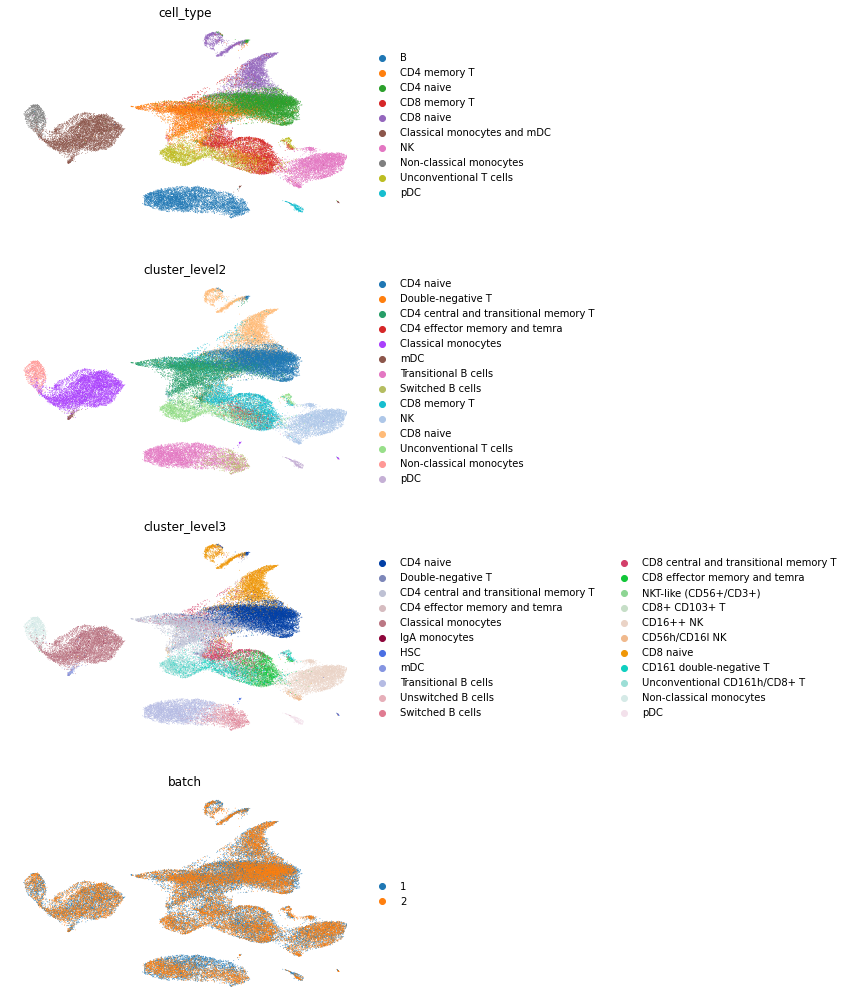

In [40]:
sc.pl.umap(latent, color=['cell_type', 'cluster_level2', 'cluster_level3', 'batch'], ncols=1, frameon=False)